## **Libraries**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install librosa numpy scipy

In [5]:
import os
import pandas as pd
from tqdm import tqdm

In [11]:
!pip install numpy==1.24.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 110.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is

In [1]:
!pip install jams librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 7.4 MB/s eta 0:00:00
  Created wheel for jams: filename=jams-0.3.4-py3-none-any.whl size=64900 sha256=e02771f12d5c3061e4653f0869840cbbcf8940cb8f1757c7ee032e395866a08b
  Stored in directory: /root/.cache/pip/wheels/3e/b9/4f/64010f7e4412ba5c6190fe04ce93487970f4ae967c952b1460
Successfully built jams


In [2]:
import jams
import numpy as np
import librosa

In [11]:
# 🎸 Standart EADGBE akort düzenine göre açık tel MIDI değerleri
OPEN_STRING_MIDI = {
    6: 40,  # E2
    5: 45,  # A2
    4: 50,  # D3
    3: 55,  # G3
    2: 59,  # B3
    1: 64   # E4
}

## **Sample Feature Extraction**

In [6]:
from scipy.optimize import curve_fit

def harmonic_model(k, f0, B):
    return k * f0 * np.sqrt(1 + B * k**2)

def estimate_f0_B_from_harmonics(freqs, mags, num_harmonics=6):
    harmonics = []
    fundamental_guess = freqs[np.argmax(mags)]
    for k in range(1, num_harmonics+1):
        idx = np.argmin(np.abs(freqs - k * fundamental_guess))
        harmonics.append((k, freqs[idx]))
    k_vals, f_vals = zip(*harmonics)
    k_vals = np.array(k_vals)
    f_vals = np.array(f_vals)

    try:
        popt, _ = curve_fit(
            harmonic_model,
            k_vals,
            f_vals,
            p0=[fundamental_guess, 0.0001],
            bounds=([50, 0.00001], [1000, 0.1])
        )
        return popt[0], popt[1]
    except:
        return None, None


In [7]:
import librosa

def extract_harmonics_from_audio(y, sr, fmin=80, fmax=1000):
    if len(y) < 2048:
        y = np.pad(y, (0, 2048 - len(y)), mode='constant')

    spectrum = np.abs(np.fft.rfft(y))
    freqs = np.fft.rfftfreq(len(y), 1/sr)

    mask = (freqs >= fmin) & (freqs <= fmax)
    return freqs[mask], spectrum[mask]


In [9]:
audio_path = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/audio/mono_mic/00_BN1-129-Eb_comp_mic.wav"
y, sr = librosa.load(audio_path, sr=None)

start_time = 3.0
end_time = 3.1
y_seg = y[int(start_time * sr):int(end_time * sr)]

freqs, mags = extract_harmonics_from_audio(y_seg, sr)
f0, B = estimate_f0_B_from_harmonics(freqs, mags)

print(f"Estimated f0: {f0:.2f} Hz" if f0 else "f0: None")
print(f"Estimated B: {B:.6f}" if B else "B: None")


Estimated f0: 219.20 Hz
Estimated B: 0.000010


## **All Data Set Feature Extraction**

In [8]:
annotation_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/annotation"
audio_dir = "/content/drive/MyDrive/Automatic Guitar Transcription/Data Set/GuitarSet/audio/mono_mic"

results_physical = []

for fname in tqdm(sorted(os.listdir(annotation_dir))):
    if fname.endswith(".jams"):
        stem = fname.replace(".jams", "").replace("_mic", "")
        audio_file = stem + "_mic.wav"
        audio_path = os.path.join(audio_dir, audio_file)
        jam_path = os.path.join(annotation_dir, fname)

        if not os.path.exists(audio_path):
            continue

        y, sr = librosa.load(audio_path, sr=None)
        jam = jams.load(jam_path)

        for ann in jam.annotations:
            if ann.namespace == "note_midi":
                for note in ann.data:
                    start = note.time
                    end = start + note.duration
                    if end - start < 0.05:
                        continue

                    y_seg = y[int(start * sr):int(end * sr)]
                    freqs, mags = extract_harmonics_from_audio(y_seg, sr)
                    f0, B = estimate_f0_B_from_harmonics(freqs, mags)

                    if f0 and B and B >= 0:
                        results_physical.append({
                            "filename": fname,
                            "start_time": round(start, 3),
                            "duration": round(note.duration, 3),
                            "note_midi": round(note.value),
                            "estimated_f0": round(f0, 2),
                            "estimated_B": round(B, 6)
                        })

100%|██████████| 360/360 [08:33<00:00,  1.43s/it]


In [9]:
df_physical = pd.DataFrame(results_physical)
df_physical.head()

,filename,start_time,duration,note_midi,estimated_f0,estimated_B
0,00_BN1-129-Eb_comp.jams,7.457,0.464,44,103.35,0.00001
1,00_BN1-129-Eb_comp.jams,7.924,0.923,44,216.91,0.00001
2,00_BN1-129-Eb_comp.jams,8.871,0.192,44,104.39,0.00001
3,00_BN1-129-Eb_comp.jams,14.835,0.488,46,197.77,0.00001
4,00_BN1-129-Eb_comp.jams,15.333,1.416,46,198.32,0.00001


In [12]:
lookup_table = []

for string, open_midi in OPEN_STRING_MIDI.items():
    for fret in range(0, 25):  # 0–24 fret
        midi = open_midi + fret
        f0 = librosa.midi_to_hz(midi)

        # Basit model: B değeri küçük ve fret arttıkça artıyor (örnek bir eğri)
        # Gerçek uygulamada deneysel ölçüm ya da kayıt üzerinden oluşturulur
        B = 0.00001 + 0.00001 * fret  # çok kaba bir model

        lookup_table.append({
            "string": string,
            "fret": fret,
            "ref_f0": f0,
            "ref_B": B
        })

df_lookup = pd.DataFrame(lookup_table)
df_lookup.head()

,string,fret,ref_f0,ref_B
0,6,0,82.406889,0.00001
1,6,1,87.307058,0.00002
2,6,2,92.498606,0.00003
3,6,3,97.998859,0.00004
4,6,4,103.826174,0.00005


In [13]:
def match_fret_string_from_f0_B(f0, B, lookup_df):
    min_dist = float("inf")
    best_match = None

    for _, row in lookup_df.iterrows():
        dist = np.sqrt((f0 - row.ref_f0) ** 2 + (B - row.ref_B) ** 2)
        if dist < min_dist:
            min_dist = dist
            best_match = (int(row.string), int(row.fret), round(row.ref_f0, 2), round(row.ref_B, 6))
    return best_match


In [14]:
matched_physical = []

for _, row in df_physical.iterrows():
    f0 = row['estimated_f0']
    B = row['estimated_B']
    match = match_fret_string_from_f0_B(f0, B, df_lookup)

    if match:
        string, fret, ref_f0, ref_B = match
        matched_physical.append({
            "filename": row['filename'],
            "note_midi": row['note_midi'],
            "start_time": row['start_time'],
            "duration": row['duration'],
            "estimated_f0": f0,
            "estimated_B": B,
            "matched_string": string,
            "matched_fret": fret,
            "matched_ref_f0": ref_f0,
            "matched_ref_B": ref_B
        })

df_matched_physical = pd.DataFrame(matched_physical)
df_matched_physical.head()

,filename,note_midi,start_time,duration,estimated_f0,estimated_B,matched_string,matched_fret,matched_ref_f0,matched_ref_B
0,00_BN1-129-Eb_comp.jams,44,7.457,0.464,103.35,0.00001,6,4,103.83,0.00005
1,00_BN1-129-Eb_comp.jams,44,7.924,0.923,216.91,0.00001,3,2,220.00,0.00003
2,00_BN1-129-Eb_comp.jams,44,8.871,0.192,104.39,0.00001,6,4,103.83,0.00005
3,00_BN1-129-Eb_comp.jams,46,14.835,0.488,197.77,0.00001,3,0,196.00,0.00001
4,00_BN1-129-Eb_comp.jams,46,15.333,1.416,198.32,0.00001,3,0,196.00,0.00001


In [20]:
save_path = "/content/drive/MyDrive/Automatic Guitar Transcription/feature_extraction/fret_string_inference_physical_model/fret_string_physical_inference_results.csv"
df_matched_physical.to_csv(save_path, index=False)
print(f"✅ Saved to {save_path}")

✅ Saved to /content/drive/MyDrive/Automatic Guitar Transcription/feature_extraction/fret_string_inference_physical_model/fret_string_physical_inference_results.csv


## **Inspect Results**

In [15]:
print("📊 Summary (Physical Model Inference):")
print(f"Total Notes: {len(df_matched_physical)}")
print(f"Unique Files: {df_matched_physical['filename'].nunique()}")
print("String Usage:", df_matched_physical['matched_string'].value_counts().sort_index().to_dict())
print(f"Fret Range: {df_matched_physical['matched_fret'].min()} – {df_matched_physical['matched_fret'].max()}")
print(f"Average Fret: {round(df_matched_physical['matched_fret'].mean(), 2)}")
print(f"Most Common Fret: {df_matched_physical['matched_fret'].mode().iloc[0]}")

📊 Summary (Physical Model Inference):
Total Notes: 62471
Unique Files: 360
String Usage: {3: 33720, 4: 18799, 5: 6283, 6: 3669}
Fret Range: 0 – 4
Average Fret: 1.95
Most Common Fret: 4


<ipython-input-17-271ec8bf0a25>:9: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127928 (\N{GUITAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


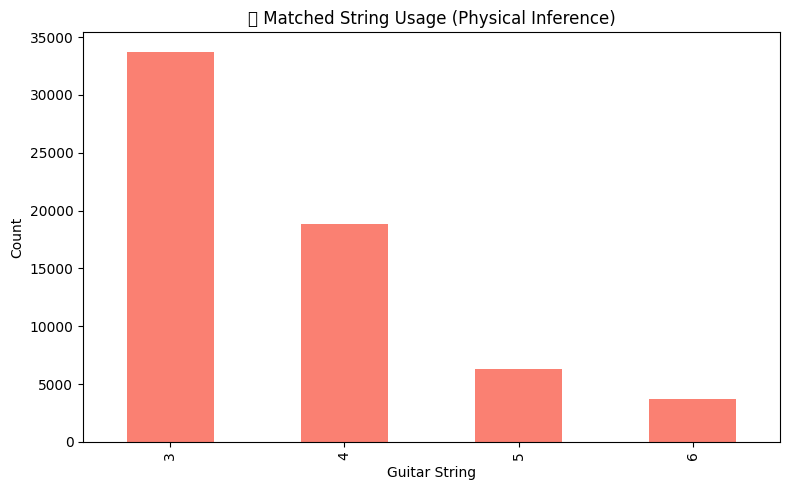

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
df_matched_physical['matched_string'].value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title("🎸 Matched String Usage (Physical Inference)")
plt.xlabel("Guitar String")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

<ipython-input-18-013d5854f66d>:7: UserWarning: Glyph 127898 (\N{LEVEL SLIDER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127898 (\N{LEVEL SLIDER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


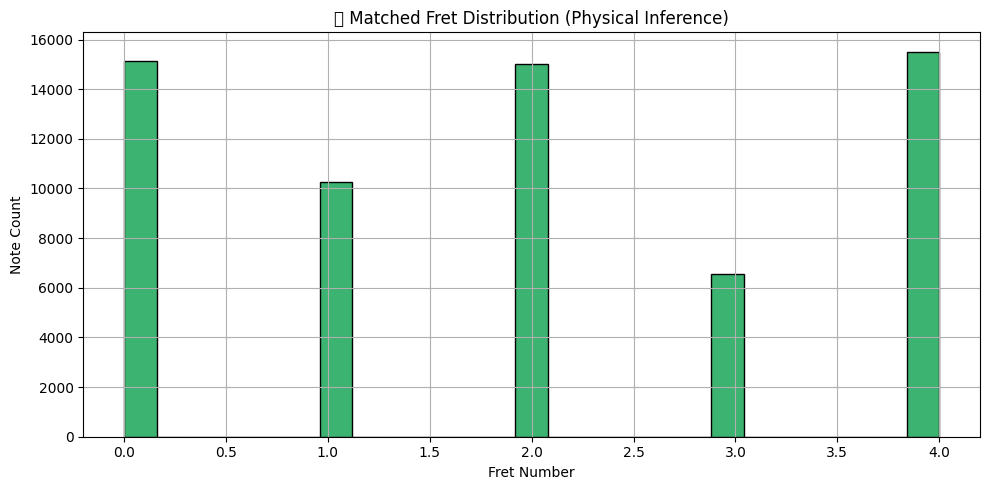

In [18]:
plt.figure(figsize=(10, 5))
df_matched_physical['matched_fret'].plot(kind='hist', bins=25, color='mediumseagreen', edgecolor='black')
plt.title("🎚️ Matched Fret Distribution (Physical Inference)")
plt.xlabel("Fret Number")
plt.ylabel("Note Count")
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-19-2f246e695648>:7: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


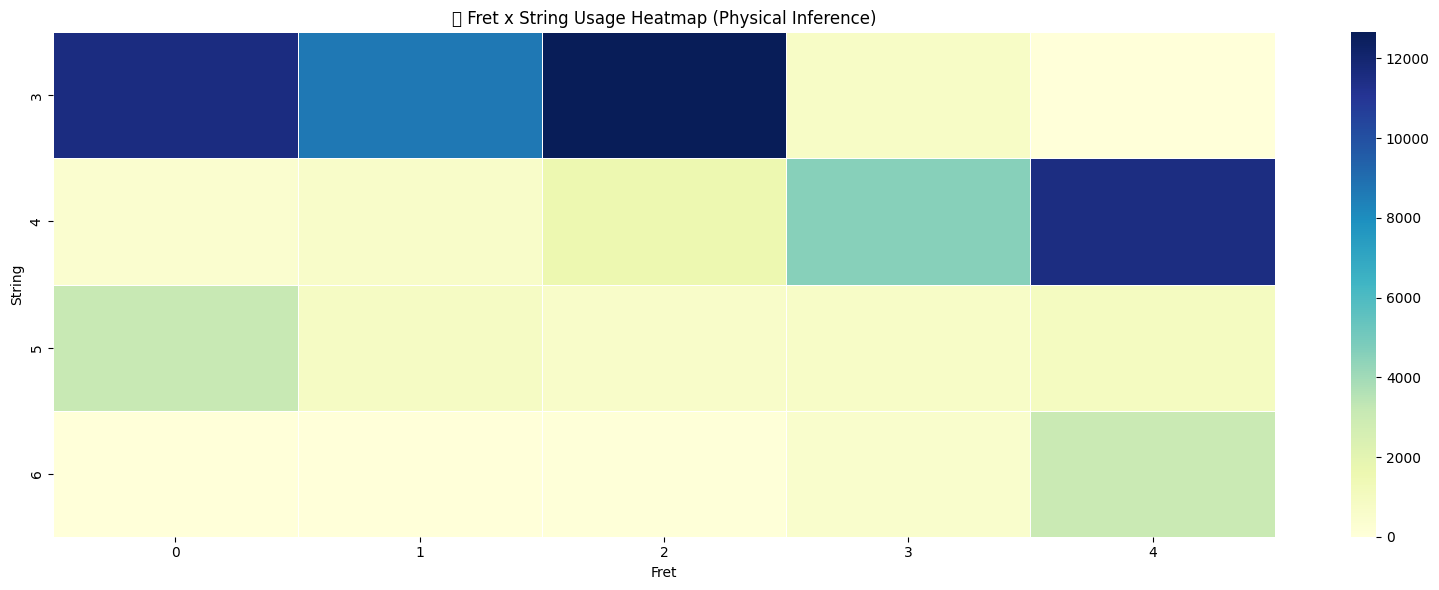

In [19]:
pivot = df_matched_physical.pivot_table(index='matched_string', columns='matched_fret', aggfunc='size', fill_value=0)
plt.figure(figsize=(16, 6))
sns.heatmap(pivot, cmap="YlGnBu", linewidths=0.5)
plt.title("🎯 Fret x String Usage Heatmap (Physical Inference)")
plt.xlabel("Fret")
plt.ylabel("String")
plt.tight_layout()
plt.show()